## Doublets Examples

One for inhibitory, the other for excitatory

In [32]:
from pathlib import Path

import sys
import os
sys.path.append(os.path.abspath("../src"))

import importlib
import utils
import plot

importlib.reload(utils)
importlib.reload(plot)

from utils import load_merfish_signal_df, load_banksy_result, load_merfish_data, load_boundaries_data
from plot import plot_doublets, plot_transcript_view
from plot import CM, SAVE_FIG, plot_doublets, BIH_CMAP, _plot_scalebar, roi_scatter_kwargs

import anndata as ad
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
fig_path = Path("../data/results/R8")

### data

#### Signals in the Tissue Section

In [3]:
MERFISH_data_folder_path = Path("../data/mouse_hypothalamus/MERFISH/")

In [4]:
signal_coordinate_df, coordinate_x_m, coordinate_y_m = load_merfish_signal_df(MERFISH_data_folder_path/"merfish_barcodes_example.csv")

#### Results of BANKSY

In [5]:
banksy_folder_path = Path("../data/banksy_results/")

In [6]:
banksy_result = load_banksy_result(banksy_folder_path/"banksy_cluster.txt", coordinate_x_m, coordinate_y_m)

#### Segmentation Dataset

In [7]:
merfish_data = load_merfish_data(MERFISH_data_folder_path / "merfish_all_cells.csv", 
                                 banksy_result, coordinate_x_m, coordinate_y_m, 
                                 animal_id=1, bregma_value=-0.24)

#### Cell boundaries

In [8]:
boundaries_df = load_boundaries_data(MERFISH_data_folder_path/'cellboundaries_example_animal.csv', 
                                     merfish_data, coordinate_x_m, coordinate_y_m)

In [9]:
MODgm_boundaries = boundaries_df[boundaries_df['banksy'] == 8]

### Doublets

In [10]:
ovrlpy_result_folder = Path("../data/results/VSI/")

signal_integrity = np.loadtxt(ovrlpy_result_folder/"SignalIntegrity.txt")
signal_strength = np.loadtxt(ovrlpy_result_folder/"SignalStrength.txt")
pseudocells = ad.read_h5ad(ovrlpy_result_folder/"pseudocells.h5ad")
doublets = pl.read_csv(ovrlpy_result_folder/"doublets_df.csv")

In [ ]:
windowsize = 60
window_size = windowsize / 2
signal_threshold=3.0

#### MODgm and Neurons

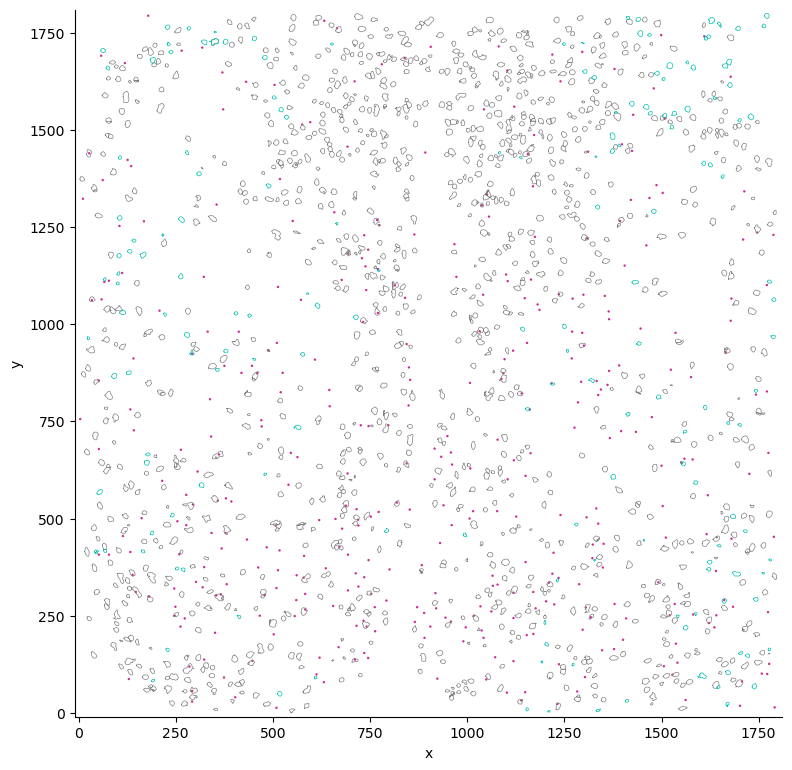

In [12]:
Neuron_boundaries = boundaries_df[boundaries_df['Cell_class'] == 'Excitatory']
plot_doublets(doublets_df=doublets, boundary_df=Neuron_boundaries, MOD_boundary=MODgm_boundaries)

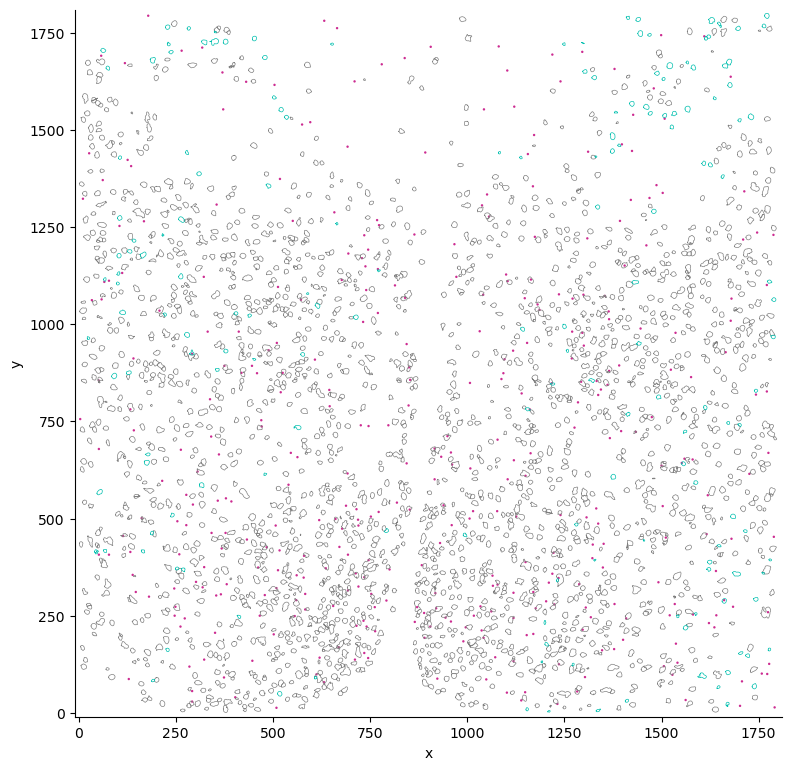

In [13]:
Neuron_boundaries = boundaries_df[boundaries_df['Cell_class'] == 'Inhibitory']
plot_doublets(doublets_df=doublets, boundary_df=Neuron_boundaries, MOD_boundary=MODgm_boundaries)

### Cell Map and corresponding UMAP

In [15]:
embedding = pseudocells.obsm["2D_UMAP"]
RGB = pseudocells.obsm["RGB"]

spatial = pseudocells.obsm["spatial"]

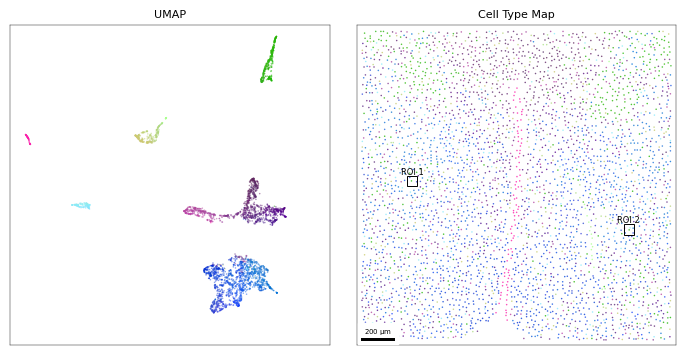

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18*CM, 9*CM))

ax[0].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=RGB,
    alpha=0.5,
    marker=".",
    edgecolors='none',
    s=5,
)
ax[0].set(aspect='equal', adjustable='box')
ax[0].set_xlim(-8,17)
ax[0].set_ylim(-8,17)
for spine in ax[0].spines.values():
        spine.set_linewidth(0.3)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("UMAP", fontsize=8)

ax[1].scatter(
    spatial[:, 0],
    spatial[:, 1],
    c=RGB,
    alpha=0.8,
    marker=".",
    edgecolors='none',
    s=5,
)
ax[1].set(aspect="equal")

x_center, y_center = doublets["x", "y"].row(49)
x0 = x_center - window_size
y0 = y_center - window_size
square = Rectangle(
    (x0, y0),
    width=windowsize,
    height=windowsize,
    linewidth=0.7,
    fill=False,
    edgecolor="k",
)
ax[1].add_patch(square)
ax[1].text(
            x0 + windowsize / 2, y0 + windowsize + 10,
            "ROI 1",
            color="k",
            fontsize=6,
            fontweight='light',
            ha='center'
        )

x_center, y_center = doublets["x", "y"].row(158)
x0 = x_center - window_size
y0 = y_center - window_size
square = Rectangle(
    (x0, y0),
    width=windowsize,
    height=windowsize,
    linewidth=0.7,
    fill=False,
    edgecolor="k",
)
ax[1].add_patch(square)
ax[1].text(
            x0 + windowsize / 2, y0 + windowsize + 10,
            "ROI 2",
            color="k",
            fontsize=6,
            fontweight='light',
            ha='center'
        )

_plot_scalebar(ax[1], dx=1, units="um", location="lower left", length_fraction=0.25, fontsize=5, box_alpha=1)
ax[1].set_xticks([])
ax[1].set_yticks([])
for spine in ax[1].spines.values():
        spine.set_linewidth(0.3)
ax[1].set_xlim(-30,1830)
ax[1].set_ylim(-30,1830)
ax[1].set_aspect('equal')
ax[1].set_title("Cell Type Map", fontsize=8)

plt.tight_layout()
plt.savefig(fig_path/"CTnUMAP.pdf", **SAVE_FIG)
plt.show()

### Doublet1: Inhibitory

doublet_to_show = 49  
x,y = 292, 924

In [38]:
ROI_in = pl.read_parquet(ovrlpy_result_folder/"roi_transcripts_In.parquet")

doublet_to_show = 49
x, y = doublets["x", "y"].row(doublet_to_show)
roi = ((x - window_size, x + window_size), (y - window_size, y + window_size))

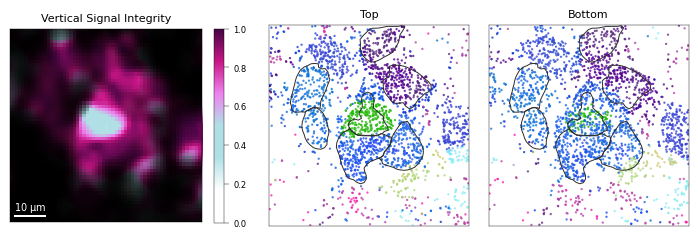

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(18*CM, 6*CM), sharey=True, width_ratios=[1.2, 1, 1])

# ax[0]: Vertical Signal Integrity
ax[0].set_facecolor("black")
img = ax[0].imshow(
    signal_integrity,
    cmap=BIH_CMAP,
    alpha=((signal_strength / signal_threshold).clip(0, 1) ** 2),
    vmin=0,
    vmax=1,
    rasterized=True
)
ax[0].invert_yaxis()
ax[0].set(xlim=roi[0], ylim=roi[1])
ax[0].set(xticks=[], yticks=[])
ax[0].set_title("Vertical Signal Integrity", fontsize=8)
ax[0].set_aspect('equal')
_plot_scalebar(ax[0], dx=1, units="um", location="lower left", length_fraction=0.2, fontsize=7, color="white")
for spine in ax[0].spines.values():
    spine.set_linewidth(0.3)
cbar = fig.colorbar(img, ax=ax[0], shrink=0.95)
cbar.ax.tick_params(labelsize=6, width=0.3)
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.3)

# ax[1]: Top transcripts
roi_top = ROI_in.filter(pl.col("z") > pl.col("z_center"))
plot_transcript_view(ax[1], roi, roi_top, boundaries_df, title="Top")

# ax[2]: Bottom transcripts
roi_bottom = ROI_in.filter(pl.col("z") < pl.col("z_center"))[::-1]
plot_transcript_view(ax[2], roi, roi_bottom, boundaries_df, title="Bottom")

plt.tight_layout()
plt.savefig(fig_path/"InDoublet.pdf", **SAVE_FIG)
plt.show()

#### Doublet2: Excitatory

doublet_to_show = 158  

In [41]:
ROI_ex =pl.read_parquet(ovrlpy_result_folder/"roi_transcripts_Ex.parquet")

doublet_to_show = 158
x, y = doublets["x", "y"].row(doublet_to_show)
roi = ((x - window_size, x + window_size), (y - window_size, y + window_size))

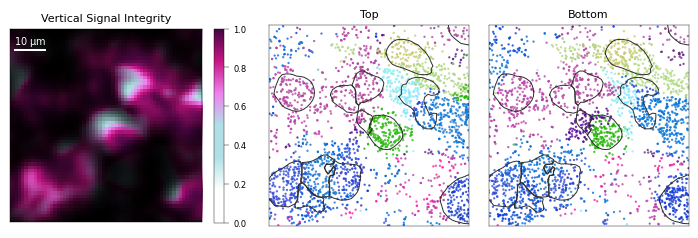

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18*CM, 6*CM), sharey=True, width_ratios=[1.2, 1, 1])

# ax[0]: Vertical Signal Integrity
ax[0].set_facecolor("black")
img = ax[0].imshow(
    signal_integrity,
    cmap=BIH_CMAP,
    alpha=((signal_strength / signal_threshold).clip(0, 1) ** 2),
    vmin=0,
    vmax=1,
    rasterized=True
)
ax[0].invert_yaxis()
ax[0].set(xlim=roi[0], ylim=roi[1])
ax[0].set(xticks=[], yticks=[])
ax[0].set_title("Vertical Signal Integrity", fontsize=8)
ax[0].set_aspect('equal')
_plot_scalebar(ax[0], dx=1, units="um", location="upper left", length_fraction=0.2, fontsize=7, color="white")
for spine in ax[0].spines.values():
    spine.set_linewidth(0.3)
cbar = fig.colorbar(img, ax=ax[0], shrink=0.95)
cbar.ax.tick_params(labelsize=6, width=0.3)
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.3)

# ax[1]: Top transcripts
roi_top = ROI_ex.filter(pl.col("z") > pl.col("z_center"))
plot_transcript_view(ax[1], roi, roi_top, boundaries_df, title="Top")

# ax[2]: Bottom transcripts
roi_bottom = ROI_ex.filter(pl.col("z") < pl.col("z_center"))[::-1]
plot_transcript_view(ax[2], roi, roi_bottom, boundaries_df, title="Bottom")

plt.tight_layout()
plt.savefig(fig_path/"ExDoublet.pdf", **SAVE_FIG)
plt.show()